In [1]:
import sys
sys.path.append('../..')

from qubap.qiskit.luciano.variational_algorithms import VQE, classical_solver, energy_evaluation
from qubap.qiskit.luciano.costfunc_barren_plateaus import paulistrings2hamiltonian 
from qubap.qiskit.felipe.state_efficient_ansatz import ansatz_constructor #SAE

import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.utils import QuantumInstance

from qiskit.circuit.library import EfficientSU2
from qubap.qiskit.luciano.costfunc_barren_plateaus import paulistrings2hamiltonian 

In [2]:
molecule = np.load( 'molecule_BeH2_6.npy', allow_pickle=True )[0]
pauli_strings, coeffs = molecule['hamiltonian']
hamiltonian = paulistrings2hamiltonian( pauli_strings, coeffs )
num_qubits = hamiltonian.num_qubits

In [ ]:
hf= QuantumCircuit.from_qasm_str(molecule['initial_state'])

In [3]:
exact_energy = classical_solver( hamiltonian ).eigenvalue
exact_energy

-3.9111731691822063

In [4]:
reps   = 3
ansatz_SU = EfficientSU2( num_qubits, ['ry','rz'], 'circular', reps ).decompose()
#ansatz_SU.compose(hf, inplace=True)
t_ansatz_SU = transpile(ansatz_SU)
# ansatz.draw('mpl') 

npars_SU = ansatz_SU.num_parameters
pars_SU  = np.random.rand( npars_SU )

In [5]:
ansatz_SEA   = ansatz_constructor( num_qubits, deep=[3,3,3] )
#ansatz_SEA.compose(hf, inplace=True)
t_ansatz_SEA = transpile(ansatz_SEA)

npars_SEA = ansatz_SEA.num_parameters
pars_SEA  = np.random.rand( npars_SEA )

In [6]:
num_iters = 100
quantum_instance = QuantumInstance( AerSimulator() , shots = 2**10 )

In [7]:
results_SU  = VQE( hamiltonian,  t_ansatz_SU,  pars_SU, num_iters, quantum_instance, iter_start=5000 )

In [8]:
data_SU = [energy_evaluation(hamiltonian, ansatz_SU, x, AerSimulator(method='statevector') ) for x in results_SU['x']]

In [9]:
results_SEA = VQE( hamiltonian, t_ansatz_SEA, pars_SEA, num_iters, quantum_instance, iter_start=5000 )

In [10]:
data_SEA = [energy_evaluation(hamiltonian, t_ansatz_SEA, x, AerSimulator(method='statevector') ) for x in results_SEA['x']]

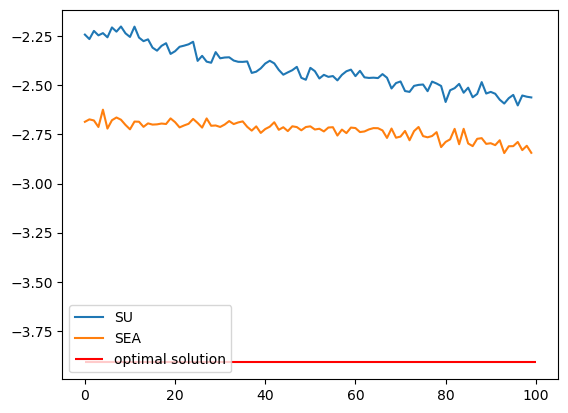

In [11]:
plt.plot( results_SU['fx'], label='SU' )
plt.plot( results_SEA['fx'], label='SEA' )
plt.hlines(exact_energy.real, 0, num_iters , 'r', label='optimal solution')
plt.legend()

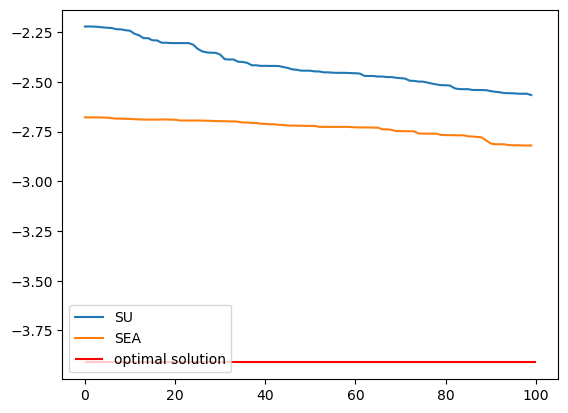

In [12]:
plt.plot( data_SU, label='SU' )
plt.plot( data_SEA, label='SEA' )
plt.hlines(exact_energy.real, 0, num_iters , 'r', label='optimal solution')
plt.legend()